# Background

The following ABM was created as practice for my coding in Mesa. The situation is one I've personally imagined involving the emerald ash borer (EAB), an invasive wood-boring beetle from Asia responsible for the death and decline of millions of ash trees in North America. The emerald ash borer lays its eggs in the bark crevices of these ash trees, and the larvae from these eggs burrow into the tree where they feed. The purpose of the ABM is to examine how pest control methods, specifically the spacing of vulnerable trees, can help mitigate the pest problem. Some assumptions are made to simplify the model.

# Import Dependencies

In [15]:
import mesa
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings

from mesa.experimental import JupyterViz

In [16]:
# To get rid of UserWarning that keeps popping up for some reason regarding placing the same agent in a different position 
warnings.simplefilter("ignore", UserWarning)

# Agent Classes

In [18]:
class Ash_Tree(mesa.Agent):
    def __init__(self, unique_id, model, pos, condition):
        """
        Initializer function for ash trees' id, position, and health condition
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.condition = condition 
    
    def maybe_spread_infection(self):
        """
        Function called in step() where ash trees that are infected with EAB spread their infection to neighboring trees
        """
        if self.condition == "Infected":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
            for neighbor in neighbors:
                if isinstance(neighbor, Ash_Tree) and neighbor.condition == "Healthy":
                    neighbor.condition = "Infected"
            self.condition = "Dead"

    def step(self):
        """
        Step function which occurs with each step of the model for each ash tree in the model
        """
        self.maybe_spread_infection()

# Model Class

In [20]:
class Forest(mesa.Model):
    def __init__(self, width, height, tree_density):
        """
        Initializer function which creates the ash trees and adds them to the grid and scheduler
        """
        super().__init__()
        self.width = width
        self.height = height
        self.tree_density = tree_density
        self.running = True
        
        # Initialize scheduler
        self.schedule = mesa.time.RandomActivation(self)
        # Initialize grid class
        self.grid = mesa.space.SingleGrid(self.width, self.height, torus=False)
        # Initialize data collector 
        self.datacollector = mesa.DataCollector(
            {
                "Healthy": lambda m: self.count_type(m, "Healthy"),
                "Infected": lambda m: self.count_type(m, "Infected"),
                "Dead": lambda m: self.count_type(m, "Dead"),
            }
        )

        # Create a list of all possible positions
        all_possible_positions = [(x, y) for x in range(self.width) for y in range(self.height)]
        # Shuffle the positions
        self.random.shuffle(all_possible_positions)
        # Calculate the number of trees to create so that we can place an ash tree with probability given by the model 
        num_of_agents = int(self.width*self.height*self.tree_density)

        # Create ash trees and add them to the scheduler and grid        
        for i in range(num_of_agents):
            x,y = all_possible_positions[i]
            if x == 0: 
                condition = "Infected"
            else: 
                condition = "Healthy"
            new_tree = Ash_Tree(i, self, (x,y), condition)
            self.grid.place_agent(new_tree, (x,y))
            self.schedule.add(new_tree)
                                    
    def step(self):
        """
        Step function that advances the model 
        """
        self.schedule.step()
        self.datacollector.collect(self)
        if self.count_type(self, "Infected") == 0:
            self.running = False

    @staticmethod
    def count_type(model, tree_condition):
        """
        Helper method to count trees in a given condition in a given model.
        """
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

# Running the Model

In [30]:
def run_model(width, height, tree_density, max_steps):
    model = Forest(width, height, tree_density)
    for i in range(max_steps):
        if not model.running:
            break
        model.step()
    return model.datacollector.get_model_vars_dataframe()

# Getting Results

   Healthy  Infected  Dead
0      721         6    23
1      716         5    29
2      712         3    35
3      709         3    38
4      706         2    42
5      704         2    44
6      703         0    47


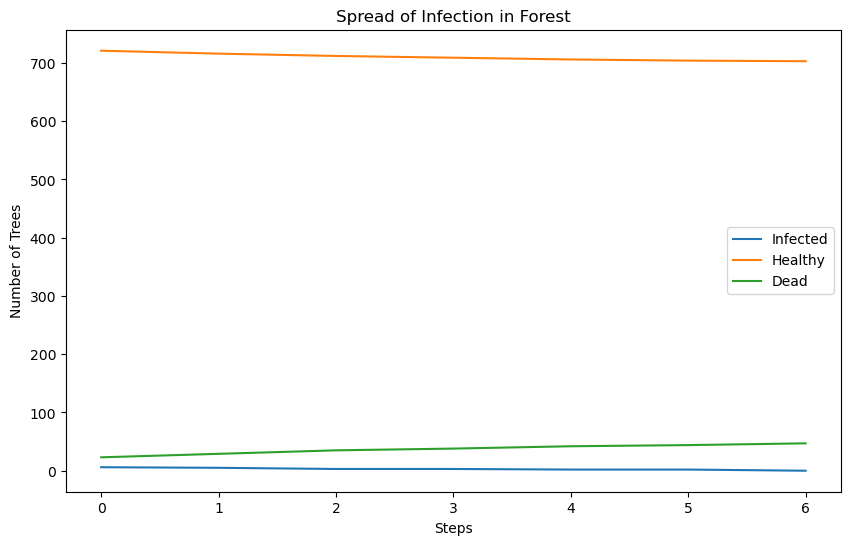

In [28]:
results = run_model(50, 50, 0.3, 100)
print(results)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results["Infected"], label="Infected")
plt.plot(results["Healthy"], label="Healthy")
plt.plot(results["Dead"], label="Dead")
plt.xlabel("Steps")
plt.ylabel("Number of Trees")
plt.title("Spread of Infection in Forest")
plt.legend()
plt.show()

    Healthy  Infected  Dead
0      1636        47    67
1      1560        43   147
2      1443        64   243
3      1282        81   387
4      1134        74   542
5      1032        55   663
6       897        69   784
7       740        79   931
8       582        76  1092
9       455        70  1225
10      347        70  1333
11      247        59  1444
12      141        56  1553
13       63        36  1651
14       15        21  1714
15        0         2  1748
16        0         0  1750


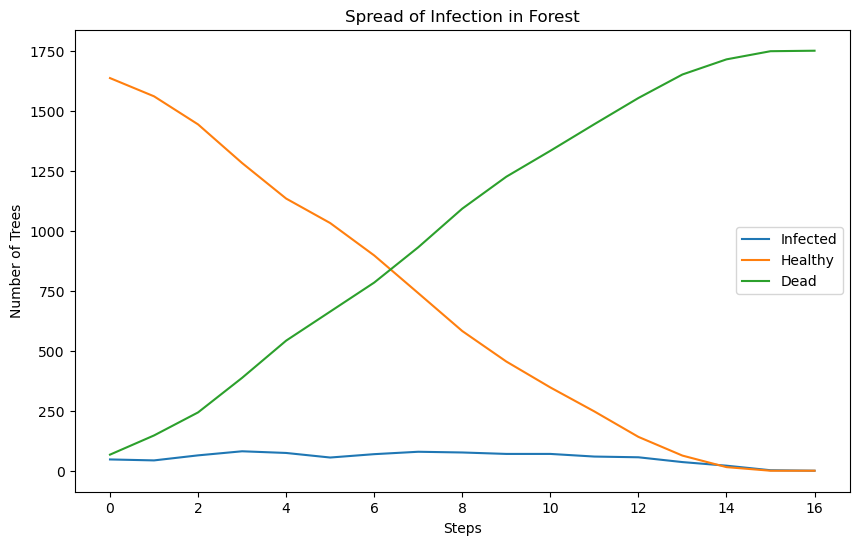

In [24]:
results = run_model(50, 50, 0.7, 100)
print(results)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results["Infected"], label="Infected")
plt.plot(results["Healthy"], label="Healthy")
plt.plot(results["Dead"], label="Dead")
plt.xlabel("Steps")
plt.ylabel("Number of Trees")
plt.title("Spread of Infection in Forest")
plt.legend()
plt.show()

# Visualization 

In [90]:
model_params = {
    "tree_density": {
        "type": "SliderFloat",
        "value": 0.4,
        "label": "Tree Density:",
        "min": 0,
        "max": 1,
        "step": 0.05,
    },
    "width": 50,
    "height": 50,
}

def tree_portrayal(ash_tree):
    size = 20
    if ash_tree.condition == "Healthy":
        color = "tab:green"
    elif ash_tree.condition == "Infected":
        color = "tab:red"
    elif ash_tree.condition == "Dead":
        color = "tab:blue"
    return {"size": size, "color": color}

page = JupyterViz(
    Forest,
    model_params,
    measures=["Healthy"],
    name="EAB Infection Model",
    agent_portrayal=tree_portrayal,
)

page

# Do you have to manually set the tree density? Slider does not seem to be working 

Cannot show ipywidgets in text